In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [110]:
df = pd.read_csv('../data/all_data/cleaned_recent_data.csv')

In [111]:
df

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,BMI
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,24.691358
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,20.761246
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,23.959094
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,23.959094
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN,23.959094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196079,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN,27.776911
196080,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,19.047004
196081,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN,19.047004
196082,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN,28.049671


In [112]:
df['Medal'] = df['Medal'].fillna('none')

In [113]:
df = df[df['Season'] == 'Summer']

In [114]:
df['Sport'].nunique()

36

In [115]:
df['Event'].nunique()

375

In [116]:
feat = df.drop(columns=['Name', 'Games', 'Season', 'City', 'Team', 'Event', 'Sport'])

In [117]:
feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157400 entries, 0 to 196078
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      157400 non-null  int64  
 1   Sex     157400 non-null  object 
 2   Age     157400 non-null  float64
 3   Height  157400 non-null  float64
 4   Weight  157400 non-null  float64
 5   NOC     157400 non-null  object 
 6   Year    157400 non-null  int64  
 7   Medal   157400 non-null  object 
 8   BMI     157400 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 12.0+ MB


In [118]:
host_countries = pd.read_csv('../data/all_data/host_country.csv')
host_countries_recent = host_countries[host_countries['Year'] >= 1960].reset_index(drop=True)

noc_regions = pd.read_csv('../data/all_data/noc_regions.csv')

In [119]:
noc_regions = noc_regions.drop_duplicates(subset=['region'])

In [120]:
# Merge host countries with NOC regions on the Host_Country and region columns
host_nocs = host_countries_recent.merge(noc_regions, left_on='Host_Country', right_on='region', how='left')
host_nocs = host_nocs[['Year', 'Host_City', 'Host_Country', 'NOC']]

In [121]:
feat_df = pd.merge(feat, host_nocs[['Year', 'NOC']], on=['Year', 'NOC'], how='left', indicator='Host_Indicator')

In [122]:
# Convert Host_Indicator to 1 or 0
feat_df['Host'] = (feat_df['Host_Indicator'] == 'both').astype(int)
# Drop the Host_Indicator column
feat_df.drop(columns=['Host_Indicator'], inplace=True)

In [123]:
feat_df = feat_df.drop(columns=['NOC'])

In [124]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157400 entries, 0 to 157399
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      157400 non-null  int64  
 1   Sex     157400 non-null  object 
 2   Age     157400 non-null  float64
 3   Height  157400 non-null  float64
 4   Weight  157400 non-null  float64
 5   Year    157400 non-null  int64  
 6   Medal   157400 non-null  object 
 7   BMI     157400 non-null  float64
 8   Host    157400 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 10.8+ MB


In [125]:
feat_df = feat_df[feat_df['Medal'] != 'none']

In [126]:
feat_df['Medal'].value_counts()

Medal
Bronze    7901
Gold      7632
Silver    7541
Name: count, dtype: int64

In [127]:
label_encoders = {}
for column in ['Sex', 'Medal']:
    le = LabelEncoder()
    feat_df[column] = le.fit_transform(feat_df[column])
    label_encoders[column] = le

In [128]:
feat_df

,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host
11,30,1,26.0,189.0,72.0,1996,2,20.156211,0
21,37,0,23.0,182.0,64.0,1996,0,19.321338,0
41,62,1,21.0,198.0,90.0,2016,0,22.956841,0
42,63,1,30.0,194.0,87.0,2008,0,23.116165,0
43,65,0,21.0,165.0,49.0,2016,0,17.998163,0
...,...,...,...,...,...,...,...,...,...
157372,135545,1,31.0,197.0,93.0,1996,1,23.963514,0
157379,135553,0,33.0,168.0,80.0,1964,0,28.344671,0
157381,135554,1,28.0,182.0,82.0,1980,0,24.755464,0
157392,135563,0,19.0,171.0,64.0,2000,0,21.887076,0


In [129]:
X = feat_df.drop(columns=['ID', 'Medal'])
y = feat_df['Medal']

In [158]:
feat_df = feat_df.reset_index(drop=True)

In [159]:
feat_df

,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host
0,30,1,26.0,189.0,72.0,1996,2,20.156211,0
1,37,0,23.0,182.0,64.0,1996,0,19.321338,0
2,62,1,21.0,198.0,90.0,2016,0,22.956841,0
3,63,1,30.0,194.0,87.0,2008,0,23.116165,0
4,65,0,21.0,165.0,49.0,2016,0,17.998163,0
...,...,...,...,...,...,...,...,...,...
23069,135545,1,31.0,197.0,93.0,1996,1,23.963514,0
23070,135553,0,33.0,168.0,80.0,1964,0,28.344671,0
23071,135554,1,28.0,182.0,82.0,1980,0,24.755464,0
23072,135563,0,19.0,171.0,64.0,2000,0,21.887076,0


In [130]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [131]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
X.shape

(23074, 7)

In [133]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

In [134]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [148]:
# Predict and evaluate
y_pred = rf_clf.predict(X)

In [151]:
y_pred_proba = rf_clf.predict_proba(X)

# Map the encoded labels to the actual medal names
medal_map = {0: 'Bronze', 1: 'Silver', 2: 'Gold'}

# Get the class probabilities for each class
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=[medal_map[i] for i in range(3)])

In [152]:
y_pred_proba_df

,Bronze,Silver,Gold
0,0.000000,0.200000,0.8
1,0.700000,0.100000,0.2
2,0.600000,0.300000,0.1
3,0.375000,0.025000,0.6
4,0.633333,0.266667,0.1
...,...,...,...
23069,0.433333,0.166667,0.4
23070,1.000000,0.000000,0.0
23071,0.800000,0.200000,0.0
23072,0.300000,0.300000,0.4


In [162]:
rf_preds = pd.concat([y_pred_proba_df, feat_df], axis=1)

In [163]:
rf_preds

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host
0,0.000000,0.200000,0.8,30,1,26.0,189.0,72.0,1996,2,20.156211,0
1,0.700000,0.100000,0.2,37,0,23.0,182.0,64.0,1996,0,19.321338,0
2,0.600000,0.300000,0.1,62,1,21.0,198.0,90.0,2016,0,22.956841,0
3,0.375000,0.025000,0.6,63,1,30.0,194.0,87.0,2008,0,23.116165,0
4,0.633333,0.266667,0.1,65,0,21.0,165.0,49.0,2016,0,17.998163,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23069,0.433333,0.166667,0.4,135545,1,31.0,197.0,93.0,1996,1,23.963514,0
23070,1.000000,0.000000,0.0,135553,0,33.0,168.0,80.0,1964,0,28.344671,0
23071,0.800000,0.200000,0.0,135554,1,28.0,182.0,82.0,1980,0,24.755464,0
23072,0.300000,0.300000,0.4,135563,0,19.0,171.0,64.0,2000,0,21.887076,0


In [164]:
# join with df to join 'Event', 'Name', 'Team', 'Event', 'Sport'
rf_preds = pd.merge(rf_preds, df[['ID', 'Event', 'Name', 'Team', 'Sport']], on='ID', how='left')

In [166]:
rf_preds = rf_preds.drop_duplicates(subset=['ID'])
rf_preds

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Event,Name,Team,Sport
0,0.000000,0.200000,0.8,30,1,26.0,189.0,72.0,1996,2,20.156211,0,Rowing Men's Lightweight Double Sculls,Pepijn Aardewijn,Netherlands,Rowing
2,0.700000,0.100000,0.2,37,0,23.0,182.0,64.0,1996,0,19.321338,0,Football Women's Football,Ann Kristin Aarnes,Norway,Football
3,0.600000,0.300000,0.1,62,1,21.0,198.0,90.0,2016,0,22.956841,0,Rowing Men's Coxless Pairs,Giovanni Abagnale,Italy,Rowing
4,0.375000,0.025000,0.6,63,1,30.0,194.0,87.0,2008,0,23.116165,0,"Fencing Men's epee, Individual",Jos Luis Abajo Gmez,Spain,Fencing
5,0.633333,0.266667,0.1,65,0,21.0,165.0,49.0,2016,0,17.998163,0,Taekwondo Women's Flyweight,Patimat Abakarova,Azerbaijan,Taekwondo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81060,0.443333,0.556667,0.0,135544,1,21.0,175.0,70.0,1980,2,22.857143,0,Athletics Men's 100 metres,Krzysztof Zwoliski,Poland,Athletics
81062,0.800000,0.100000,0.1,135545,1,27.0,197.0,93.0,1992,0,23.963514,0,Rowing Men's Single Sculls,Henk Jan Zwolle,Netherlands,Rowing
81068,1.000000,0.000000,0.0,135553,0,33.0,168.0,80.0,1964,0,28.344671,0,Athletics Women's Shot Put,Galina Ivanovna Zybina (-Fyodorova),Soviet Union,Athletics
81070,0.800000,0.200000,0.0,135554,1,28.0,182.0,82.0,1980,0,24.755464,0,"Fencing Men's Foil, Individual",Bogusaw Zych,Poland,Fencing


In [167]:
def get_top_probable_winners(event_df):
    gold_winner = event_df.loc[event_df['Gold'].idxmax()]
    silver_winner = event_df.loc[event_df['Silver'].idxmax()]
    bronze_winner = event_df.loc[event_df['Bronze'].idxmax()]
    return pd.DataFrame([gold_winner, silver_winner, bronze_winner], index=['Gold', 'Silver', 'Bronze'])

In [172]:
top_probable_winners = rf_preds.groupby('Event').apply(get_top_probable_winners)

In [175]:
top_probable_winners = top_probable_winners.reset_index(drop=True)
top_probable_winners

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Event,Name,Team,Sport
0,0.00,0.0,1.00,85360,1,20.0,181.0,78.0,2008,2,23.808797,0,Archery Men's Individual,Mauro Nespoli,Italy,Archery
1,0.00,1.0,0.00,64487,1,23.0,181.0,84.0,2016,1,25.640243,0,Archery Men's Individual,Ku Bon-Chan,South Korea,Archery
2,1.00,0.0,0.00,122927,1,25.0,186.0,102.0,2016,0,29.483177,0,Archery Men's Individual,Ryan Tyack,Australia,Archery
3,0.05,0.0,0.95,46943,0,19.0,170.0,68.0,1996,2,23.529412,0,Archery Women's Individual,He Ying,China,Archery
4,0.00,1.0,0.00,55856,0,26.0,165.0,59.0,2008,1,21.671258,0,Archery Women's Individual,Joo Hyun-Jung,South Korea,Archery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,0.20,0.7,0.10,133130,0,21.0,157.0,55.0,2004,1,22.313278,0,"Wrestling Women's Lightweight, Freestyle",Saori Yoshida,Japan,Wrestling
1079,1.00,0.0,0.00,111288,0,31.0,160.0,58.0,2016,0,22.656250,0,"Wrestling Women's Lightweight, Freestyle",Nataliya Siniin,Ukraine,Wrestling
1080,0.00,0.1,0.90,57752,0,26.0,164.0,63.0,2008,2,23.423557,0,"Wrestling Women's Middleweight, Freestyle",Alyona Vladimirovna Kartashova,Russia,Wrestling
1081,0.00,0.9,0.10,54909,0,24.0,170.0,63.0,2012,2,21.799308,0,"Wrestling Women's Middleweight, Freestyle",Jing Ruixue,China,Wrestling


In [ ]:
top_probable_winners.to_csv('../data/2024_result/2024_result.csv', index=False)

In [177]:
# Map actual medals to numeric values for comparison
medal_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2}

# Determine predicted medals by finding the class with the highest probability
rf_preds['Predicted_Medal'] = rf_preds[['Bronze', 'Silver', 'Gold']].idxmax(axis=1)

# Map the predicted and actual medals to numeric values
rf_preds['Predicted_Medal'] = rf_preds['Predicted_Medal'].map(medal_map)
rf_preds['Actual_Medal'] = rf_preds['Medal']

In [178]:
# Calculate accuracy
accuracy = accuracy_score(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8275


In [179]:
# Calculate confusion matrix and classification report for detailed evaluation
conf_matrix = confusion_matrix(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'])
class_report = classification_report(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'], target_names=['Bronze', 'Silver', 'Gold'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[5070  465  458]
 [ 444 4048  363]
 [ 589  504 4428]]

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.83      0.85      0.84      5993
      Silver       0.81      0.83      0.82      4855
        Gold       0.84      0.80      0.82      5521

    accuracy                           0.83     16369
   macro avg       0.83      0.83      0.83     16369
weighted avg       0.83      0.83      0.83     16369



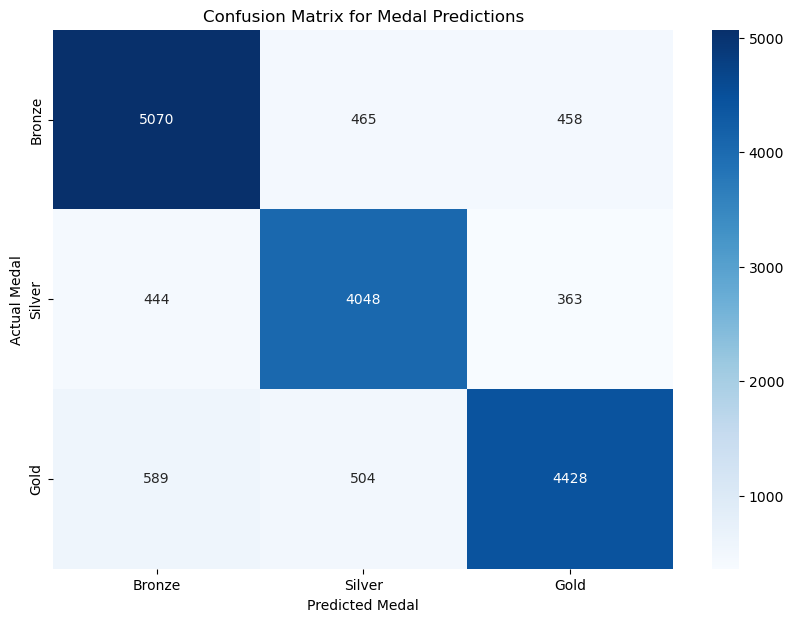

In [180]:

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bronze', 'Silver', 'Gold'], yticklabels=['Bronze', 'Silver', 'Gold'])
plt.xlabel('Predicted Medal')
plt.ylabel('Actual Medal')
plt.title('Confusion Matrix for Medal Predictions')
plt.show()


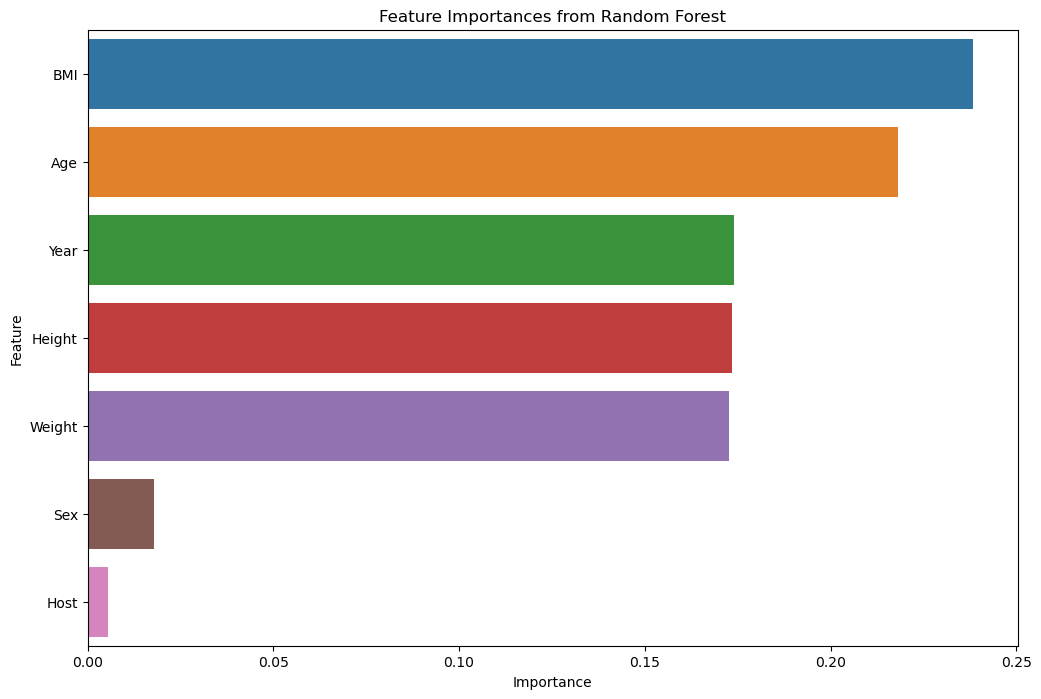

In [187]:
feature_importances = rf_clf.feature_importances_

# Map feature importances to their corresponding feature names
feature_names = feat_df.drop(columns=['ID', 'Medal']).columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the dataframe by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Validating the XGBoost Model

In [153]:
# Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_clf.predict(X_test)


In [155]:
y_pred_proba_xgb = xgb_clf.predict_proba(X)

# Map the encoded labels to the actual medal names
medal_map = {0: 'Bronze', 1: 'Silver', 2: 'Gold'}

# Get the class probabilities for each class
y_pred_proba_df_xgb = pd.DataFrame(y_pred_proba, columns=[medal_map[i] for i in range(3)])

In [181]:
xgb_preds = pd.concat([y_pred_proba_df_xgb, feat_df], axis=1)

# join with df to join 'Event', 'Name', 'Team', 'Event', 'Sport'
xgb_preds = pd.merge(xgb_preds, df[['ID', 'Event', 'Name', 'Team', 'Sport']], on='ID', how='left')
xgb_preds = xgb_preds.drop_duplicates(subset=['ID'])

In [182]:
top_probable_winners = xgb_preds.groupby('Event').apply(get_top_probable_winners)
top_probable_winners = top_probable_winners.reset_index(drop=True)
top_probable_winners

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Event,Name,Team,Sport
0,0.00,0.0,1.00,85360,1,20.0,181.0,78.0,2008,2,23.808797,0,Archery Men's Individual,Mauro Nespoli,Italy,Archery
1,0.00,1.0,0.00,64487,1,23.0,181.0,84.0,2016,1,25.640243,0,Archery Men's Individual,Ku Bon-Chan,South Korea,Archery
2,1.00,0.0,0.00,122927,1,25.0,186.0,102.0,2016,0,29.483177,0,Archery Men's Individual,Ryan Tyack,Australia,Archery
3,0.05,0.0,0.95,46943,0,19.0,170.0,68.0,1996,2,23.529412,0,Archery Women's Individual,He Ying,China,Archery
4,0.00,1.0,0.00,55856,0,26.0,165.0,59.0,2008,1,21.671258,0,Archery Women's Individual,Joo Hyun-Jung,South Korea,Archery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,0.20,0.7,0.10,133130,0,21.0,157.0,55.0,2004,1,22.313278,0,"Wrestling Women's Lightweight, Freestyle",Saori Yoshida,Japan,Wrestling
1079,1.00,0.0,0.00,111288,0,31.0,160.0,58.0,2016,0,22.656250,0,"Wrestling Women's Lightweight, Freestyle",Nataliya Siniin,Ukraine,Wrestling
1080,0.00,0.1,0.90,57752,0,26.0,164.0,63.0,2008,2,23.423557,0,"Wrestling Women's Middleweight, Freestyle",Alyona Vladimirovna Kartashova,Russia,Wrestling
1081,0.00,0.9,0.10,54909,0,24.0,170.0,63.0,2012,2,21.799308,0,"Wrestling Women's Middleweight, Freestyle",Jing Ruixue,China,Wrestling


In [183]:
# Determine predicted medals by finding the class with the highest probability
xgb_preds['Predicted_Medal'] = xgb_preds[['Bronze', 'Silver', 'Gold']].idxmax(axis=1)

# Map the predicted and actual medals to numeric values
xgb_preds['Predicted_Medal'] = xgb_preds['Predicted_Medal'].map(medal_map)
xgb_preds['Actual_Medal'] = xgb_preds['Medal']

In [184]:
# Calculate accuracy
accuracy = accuracy_score(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8275


In [185]:
# Calculate confusion matrix and classification report for detailed evaluation
conf_matrix = confusion_matrix(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'])
class_report = classification_report(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'], target_names=['Bronze', 'Silver', 'Gold'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[5070  465  458]
 [ 444 4048  363]
 [ 589  504 4428]]

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.83      0.85      0.84      5993
      Silver       0.81      0.83      0.82      4855
        Gold       0.84      0.80      0.82      5521

    accuracy                           0.83     16369
   macro avg       0.83      0.83      0.83     16369
weighted avg       0.83      0.83      0.83     16369



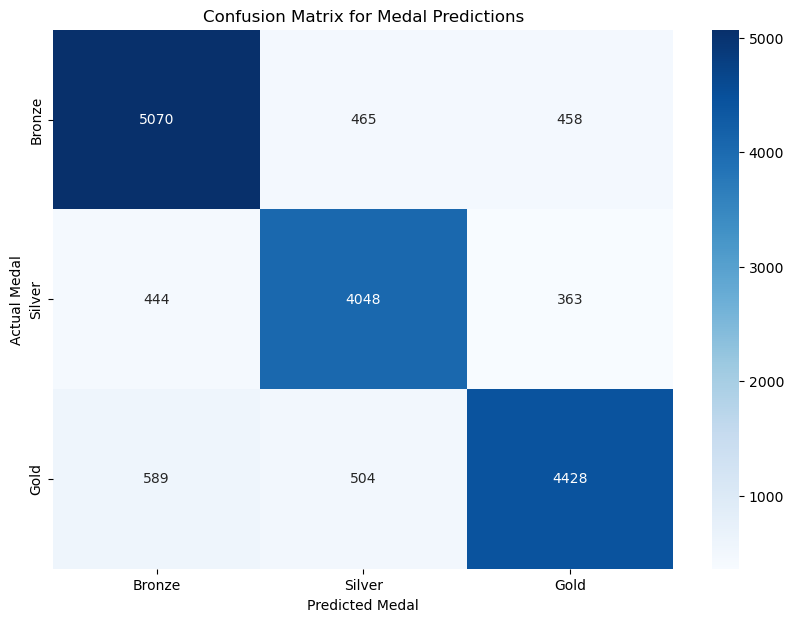

In [186]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bronze', 'Silver', 'Gold'], yticklabels=['Bronze', 'Silver', 'Gold'])
plt.xlabel('Predicted Medal')
plt.ylabel('Actual Medal')
plt.title('Confusion Matrix for Medal Predictions')
plt.show()